# Auto ML

In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import utils.eda_utils as eda_utils 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np

d:\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Load

## columns info

|column name|Description|test input|
|---|---|---|
|borehole_code|시추공 코드|X|
|x|위도|O|
|y|경도|O|
|depth_start|rockhead 시작 심도|output|
|Ground name|지반명- 0: 풍화암, 1: 연암, 2: 보통암, 4: 경암|O|
|Slope|경사|O|
|Aspect|경사방향|O|
|DEM|DEM|O|
|Rock Type|지질도에 따른 rock type|O|
|dis_bin|radius count에 따라 총 구간을 30개로 나눈 group|X|

* Rock type: {0:화성암, 1:퇴적암, 2:변성암}
* dis_bin: radius count 그룹에 따라 evaluation 하기 위한 값

In [2]:
train_df = pd.read_csv('data/241005_Rockhead_Seoul_train(before_aumentation).csv')
test_df = pd.read_csv('data/241005_Rockhead_Seoul_test(before_aumentation).csv')

C:\Users\user\AppData\Local\Temp\ipykernel_33200\2731312767.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df_copy, test_df_copy])
C:\Users\user\AppData\Local\Temp\ipykernel_33200\2731312767.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df_copy, test_df_copy])
C:\Users\user\AppData\Local\Temp\ipykernel_33200\2731312767.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entrie

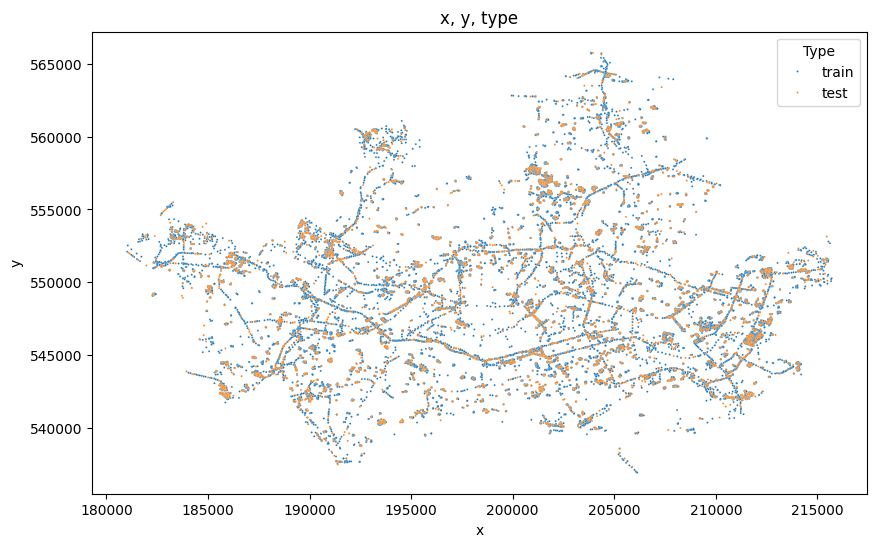

In [15]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()


train_df_copy['Type'] = 'train'
test_df_copy['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df_copy.columns)
df_concat = pd.concat([df_concat, train_df_copy, test_df_copy])

eda_utils.scatter_relation(df_concat, 'x', 'y', 2, 'x, y, type','Type')

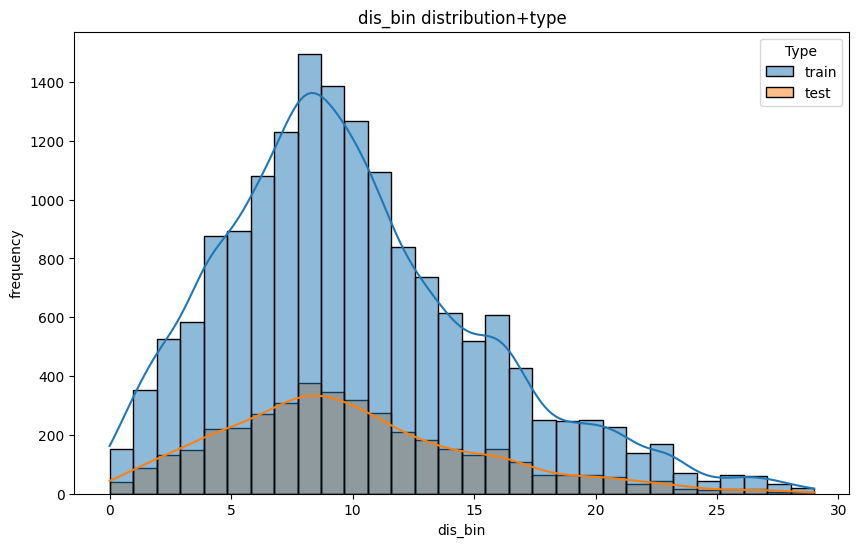

In [17]:
eda_utils.distribution_histogram(df_concat, 'dis_bin', 'dis_bin distribution+type', 'Type')

In [4]:
train_df['ground_name'] = train_df['ground_name'].astype('category')
train_df['rock_type'] = train_df['rock_type'].astype('category')

test_df['ground_name'] = test_df['ground_name'].astype('category')
test_df['rock_type'] = test_df['rock_type'].astype('category')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16247 entries, 0 to 16246
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   x            16247 non-null  float64 
 1   y            16247 non-null  float64 
 2   depth_start  16247 non-null  float64 
 3   ground_name  16247 non-null  category
 4   slope        16247 non-null  float64 
 5   aspect       16247 non-null  float64 
 6   DEM          16247 non-null  float64 
 7   rock_type    16247 non-null  category
 8   dis_bin      16247 non-null  float64 
dtypes: category(2), float64(7)
memory usage: 920.7 KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4061 entries, 0 to 4060
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   x            4061 non-null   float64 
 1   y            4061 non-null   float64 
 2   depth_start  4061 non-null   float64 
 3   ground_name  4061 non-null   category
 4   slope        4061 non-null   float64 
 5   aspect       4061 non-null   float64 
 6   DEM          4061 non-null   float64 
 7   rock_type    4061 non-null   category
 8   dis_bin      4061 non-null   float64 
dtypes: category(2), float64(7)
memory usage: 230.5 KB


## Training-Validation

In [8]:
train = TabularDataset(train_df.drop(['dis_bin'], axis=1))
test = TabularDataset(test_df.drop(['depth_start', 'dis_bin'], axis=1))
y_test = test_df['depth_start'].values.tolist()

In [9]:
hyperparameter_tune_kwargs = {  
    'num_trials': 45,
    'scheduler' : 'local',
    'searcher': 'auto',
}

predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2
                             )

predictor.fit(train,
              num_gpus=1,
              time_limit = 36000, 
              hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,  
              presets="good_quality", 
              save_space = True, 
              keep_only_best = True,
              save_bag_folds = False
              )

2024-10-06 07:09:41,616	INFO timeout.py:54 -- Reached timeout of 1727.1048945188522 seconds. Stopping all trials.
2024-10-06 07:09:41,626	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-10-06 07:09:41,629	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to 'D:/rockhead_prediction/AutogluonModels/ag-20241005_142802/models/NeuralNetTorch_BAG_L2' in 0.0105s.
2024-10-06 07:09:51,733	WARNING experiment_analysis.py:190 -- Failed to fetch metri

In [10]:
ld_board = predictor.leaderboard(train, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1\T23_FULL,0.928487,None,r2,0.068512,NaN,0.603605,0.068512,NaN,0.603605,1,True,126
1,XGBoost_BAG_L1\T5_FULL,0.927125,None,r2,0.098517,NaN,0.677619,0.098517,NaN,0.677619,1,True,108
2,XGBoost_BAG_L1\T20_FULL,0.926984,None,r2,0.657615,NaN,4.902855,0.657615,NaN,4.902855,1,True,123
3,XGBoost_BAG_L1\T12_FULL,0.924877,None,r2,4.933360,NaN,16.000289,4.933360,NaN,16.000289,1,True,115
4,NeuralNetTorch_BAG_L2\6add6170_FULL,0.923889,None,r2,272.740169,NaN,1372.057709,0.154527,NaN,19.051819,2,True,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,NeuralNetFastAI_BAG_L1\3dffccbb_FULL,0.395193,None,r2,0.084014,NaN,1.375740,0.084014,NaN,1.375740,1,True,97
137,NeuralNetFastAI_BAG_L1\96643e8e_FULL,0.355177,None,r2,0.072513,NaN,0.727627,0.072513,NaN,0.727627,1,True,96
138,NeuralNetFastAI_BAG_L1\884b0aff_FULL,0.336676,None,r2,0.101018,NaN,0.656615,0.101018,NaN,0.656615,1,True,101
139,NeuralNetFastAI_BAG_L1\8d8c7abb_FULL,0.214160,None,r2,0.076514,NaN,1.418746,0.076514,NaN,1.418746,1,True,86


## Prediction

In [11]:
pred_y = predictor.predict(test)

In [12]:
mae = mean_absolute_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y)

print('mae: ',mae)
print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2) #1에 가까울수록 좋음

mae:  2.503996684518949
mse:  12.369633282741317
rmse:  3.51704894517283
r2:  0.7556645681109563


## Evaluation

- 100 meter radius안에 포인트가 많은 순서대로 evaluation

In [14]:
for bin in test_df['dis_bin'].unique():

    bin_df = test_df[test_df['dis_bin'] == bin]
                              
    test_bin = TabularDataset(bin_df.drop(['depth_start', 'dis_bin'], axis=1))
    y_test_bin = bin_df['depth_start'].values.tolist()

    pred_y = predictor.predict(test_bin)

    mae = mean_absolute_error(y_test_bin, pred_y)
    mse = mean_squared_error(y_test_bin, pred_y)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_bin, pred_y)

    print('===== bin: {}====='.format(bin))
    print('mae: ',mae)
    print('mse: ',mse)
    print('rmse: ',rmse)
    print('r2: ',r2) #1에 가까울수록 좋음

===== bin: 0.0=====
mae:  3.1817153123805397
mse:  16.94962726879509
rmse:  4.116992502883032
r2:  0.6921398726799965
===== bin: 1.0=====
mae:  2.315784337520599
mse:  10.168632224530006
rmse:  3.1888292874548814
r2:  0.8226306364887103
===== bin: 2.0=====
mae:  2.4436515702546098
mse:  10.896756119836349
rmse:  3.301023495801923
r2:  0.6549605700761199
===== bin: 3.0=====
mae:  2.5411135688021376
mse:  11.302906141435203
rmse:  3.3619794974739516
r2:  0.7020619182865395
===== bin: 4.0=====
mae:  2.2409069451202046
mse:  9.917910067946716
rmse:  3.1492713550830636
r2:  0.6797422051482682
===== bin: 5.0=====
mae:  2.508301343981709
mse:  12.558974800952441
rmse:  3.543864388058951
r2:  0.6224593167157187
===== bin: 6.0=====
mae:  2.531710358637351
mse:  12.579971867982309
rmse:  3.5468256043936397
r2:  0.7065934552939093
===== bin: 7.0=====
mae:  2.614395663637292
mse:  12.098697915512824
rmse:  3.478318259664119
r2:  0.7347786473627165
===== bin: 8.0=====
mae:  2.460330751665095
mse:  